## i. BUSINESS JOB DESCRIPTION

*   Our client is an e-commerce company (_All in one Place_), a multibrand outlet. It profits comes from reseling large quantities of various products by offering low tag prices.

*   After collecting data from their clients database during the period of 1 year, the company's marketing team is analyzing wheter it would be profitable or not to separate it into distinct groups, in order to distinguish those who represent a larger ammount of the company's earnings.

*   The intended group of interest obtained from this clustering analysis will then be called 'Insiders', and will be targeted as eligible clients to win special fidelity programs opportunities.

## ii. THE CHALLENGE

*   I was hired as a Data Scientist consultant, in order to build a model capable of performing such clustering with great accuracy.

*   With the solution, the marketing team can acordingly plan how to target groups of clients in order to optimize profits.

*   In order to understand client's behaviour, we have a database containing information about sales transactions, specifying the products that were bought, their description, quantity, unit price as well as general information about client's physical location (Customer ID, country).

## iii. BUSINESS QUESTIONS

*   It is expected a report as the result of the clsutering analysis, which answers the following questions:

    1.  Which clients are eligible  to take part on the 'Insiders' group ?
    
    2.  How many clients will be selected?

    3.  What are the main features that impacts more the clustering analysis from said clients?

    4.  What is the 'Insiders' group percentage upon the company's total earnings?
    
    5.  What is the expected profit from the 'Insiders' group for the next months?

    6.  What are the main conditions that make one eligible for being on 'Insiders'?

    7.  What are the conditions for one to be excluded from 'Insiders'?

    8.  What guarantees that 'Insiders' group grants more profits to the company compared to the rest of the database?

    9.  Which actions the marketing team can partake to increase profits?


# 0.0 IMPORTS, FUNCTIONS AND DATABASE LOAD

In [1]:
!pip install inflection

In [2]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 8.6 MB/s eta 0:00:00


In [3]:
!pip install ydata_profiling

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.9/357.9 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.8/104.8 kB 9.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.1/686.1 kB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 15.2 MB/s eta 0:00:00
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27080 sha256=d7dcece374ee9add2fcba8ccc7c68d86bd2b8b1f0c5ca413cfee8e066ab4b3fa
  Stored in directory: /root/.cache/pip/wheels/dd/91/29/a79cecb328d01739e64017b6fb9a1ab9d8cb1853098ec5966d
Successfully built htmlmin
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.13.1
    Uninstalling seaborn-0.13.1:
      Successfully uninstalled seaborn-0.13.1


In [4]:
!pip install pandasql

  Preparing metadata (setup.py) ... done
  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26771 sha256=4f70f0c9c5556c0e0f40e847197f5765912e44b17428464328589bca39fc1788
  Stored in directory: /root/.cache/pip/wheels/e9/bc/3a/8434bdcccf5779e72894a9b24fecbdcaf97940607eaf4bcdf9
Successfully built pandasql


## 0.1 Imports

In [5]:
import pandas       as pd
import numpy        as np
import seaborn      as sns
import ipywidgets
import inflection
import optuna
import warnings
import os

from matplotlib         import pyplot as plt
from collections        import Counter
from ydata_profiling    import ProfileReport
from pandasql           import sqldf

from sklearn.preprocessing      import MinMaxScaler, StandardScaler
from sklearn.dummy              import DummyClassifier
from sklearn.ensemble           import RandomForestRegressor, ExtraTreesClassifier
from sklearn.linear_model       import LogisticRegression
from sklearn.cluster            import KMeans
from sklearn.model_selection    import train_test_split, StratifiedKFold, KFold
from sklearn.metrics            import log_loss, silhouette_score

from yellowbrick.cluster        import KElbowVisualizer, SilhouetteVisualizer
from plotly                     import express as px

from imblearn.ensemble          import BalancedRandomForestClassifier
from imblearn.pipeline          import Pipeline
from imblearn.combine           import SMOTEENN
from imblearn.under_sampling    import EditedNearestNeighbours

from IPython.core.display import HTML
from IPython.display      import Image

## 0.2 Helper Functions

In [6]:
warnings.filterwarnings ('ignore')

def jupyter_settings():
    %matplotlib inline
    %pylab inline

    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24

    display( HTML( '<style>.container { width:90% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )

    sns.set()

In [7]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.3 Database load

In [8]:
df_raw = pd.read_csv('datasets/ecommerce.csv', encoding='unicode_escape')
df_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Unnamed: 8
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom,NaN
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom,NaN
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN


In [9]:
#df_raw = pd.read_csv('/home/valquiriaam/repos/PA005/datasets/ecommerce.csv', encoding='unicode_escape')
#df_raw.head()

In [10]:

df1 = df_raw.copy()
df1 = df1.drop(columns=['Unnamed: 8'])

In [11]:
print(f'Number of Rows: {df1.shape[0]}')
print(f'Number of Columns: {df1.shape[1]}')

Number of Rows: 541909
Number of Columns: 8


# 1.0 DATA DESCRIPTION

### 1.3.1 General Description

In [12]:
df1_profile = ProfileReport(df1, title='Profile Report')
df1_profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### 1.3.2 Data Typification

*   InvoiceNo: Unique Transaction ID

*   StockCode: Item's ID code

*   Description: Item's name

*   Quantity: Quantity of product bought

*   InvoiceDate: Transaction's occurance date

*   UnitPrice:  Product's price per unit

*   CustomerID: Customer's ID code

*   Country: Customer's Country

In [13]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [14]:
cols_old = ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country']
snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))

df1.columns = cols_new
df1.columns

Index(['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date',
       'unit_price', 'customer_id', 'country'],
      dtype='object')

### 1.3.3 Missing Data Treatment

In [15]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

In [16]:
df1[df1['unit_price'] <= -0.1]

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
299983,A563186,B,Adjust bad debt,1,10-Aug-17,-11062.06,NaN,United Kingdom
299984,A563187,B,Adjust bad debt,1,10-Aug-17,-11062.06,NaN,United Kingdom


In [17]:
df1 = df1.dropna(subset=['customer_id'])
df1['customer_id'] = df1['customer_id'].astype(int64)

df1['invoice_date'] = pd.to_datetime(df1['invoice_date'])

df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,17850,United Kingdom


In [18]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id              int64
country                 object
dtype: object

In [19]:
print(f'Number of Rows: {df1.shape[0]}')
print(f'Number of Columns: {df1.shape[1]}')

Number of Rows: 406829
Number of Columns: 8


Upon Analyzing first Pandas profiling:

*   Customer_id entries with NaN values will be dropped (Not possible to identify the desired client)
*   Entry with 'unit_price' listed as a negative value (-11062,06) will be deleted. (Not a sale entry, it is descripted as a bad debt adjust)
*   Rows with quantity listed as negative values are always corrective entries from its previous ones, and its invoice_number always follows the pattern Cxxxxxx. Thus, every Cxxxxxx and its will be deleted in order to reduce noise on the dataset.

*** VERIFICAR ESTRATÉGIAS ADEQUADAS DE PREENCHIMENTO DE DADOS FALTANTES ***

## 1.4 Numerical Data Description

*** ANOTAR OBSERVAÇÕES SOBRE AS DISTRIBUIÇÕES OBSERVADAS E POSSÍVEIS INSIGHTS ***

## 1.5 Categorical Data Description

*** ANOTAR OBSERVAÇÕES SOBRE AS DISTRIBUIÇÕES OBSERVADAS E POSSÍVEIS INSIGHTS ***

# 2.0 FEATURE ENGINEERING

*   RFM Model - Recency, Frequency, Monetary




In [20]:
df2 = df1.copy()

In [21]:
df_ref = df2.copy()

#Gross Revenue -> quantity x price
df_ref['revenue'] = df_ref['quantity'] * df_ref['unit_price']
df_ref = df_ref.drop(['stock_code', 'description', 'quantity', 'unit_price', 'country'], axis = 1)
df_ref = df_ref[['customer_id','revenue']].groupby(['customer_id']).sum('revenue').reset_index()


#Frequency
df_aux = df2[['customer_id', 'invoice_no']].drop_duplicates().groupby(['customer_id']).count().reset_index()
df_aux = df_aux.rename(columns={'invoice_no' : 'frequency'})
df_ref = pd.merge(df_ref, df_aux, how='left', on='customer_id')

#Recency -> Reference point adopted as the newest data on dataset ('2017-12-07')
df_aux = df2.copy()
df_aux['recency'] = df2['invoice_date'].max() - df_aux['invoice_date']
df_aux['recency'] = df_aux['recency'].dt.days

df_aux = df_aux[['customer_id', 'recency']].groupby('customer_id').min('recency').reset_index()
df_ref = pd.merge(df_ref, df_aux, how='left', on='customer_id')


# 3.0 DATA FILTERING

In [22]:
df3 = df_ref.copy()

#   4.0 EDA (EXPLORATORY DATA ANALYSIS)

In [23]:
df4 = df3.copy()

## 4.1 Hypothesis Creation

### 4.1.1 Hypothesis Mindmap

4.1.2 Created Hypothesis

## 4.2 EDA

### 4.2.1 Bivariative Analysis

***Validação das Hipóteses/ Feature Engineering/ Mapa de Calor ***

# 5.0 DATA PREPARATION

In [24]:
df5 = df4.copy()

## 5.1 Numerical Values (Reescaling, Standarziation)

## 5.2 Categorical Values (Encoding)

#   6.0 FEATURE SELECTION

In [25]:
df6 = df5.copy()

# 7.0 HYPERPARAMETER FINE-TUNNING





In [26]:
df7 = df6.copy()

In [27]:
X = df7.drop(columns=['customer_id'])

##  4.1 KMeans

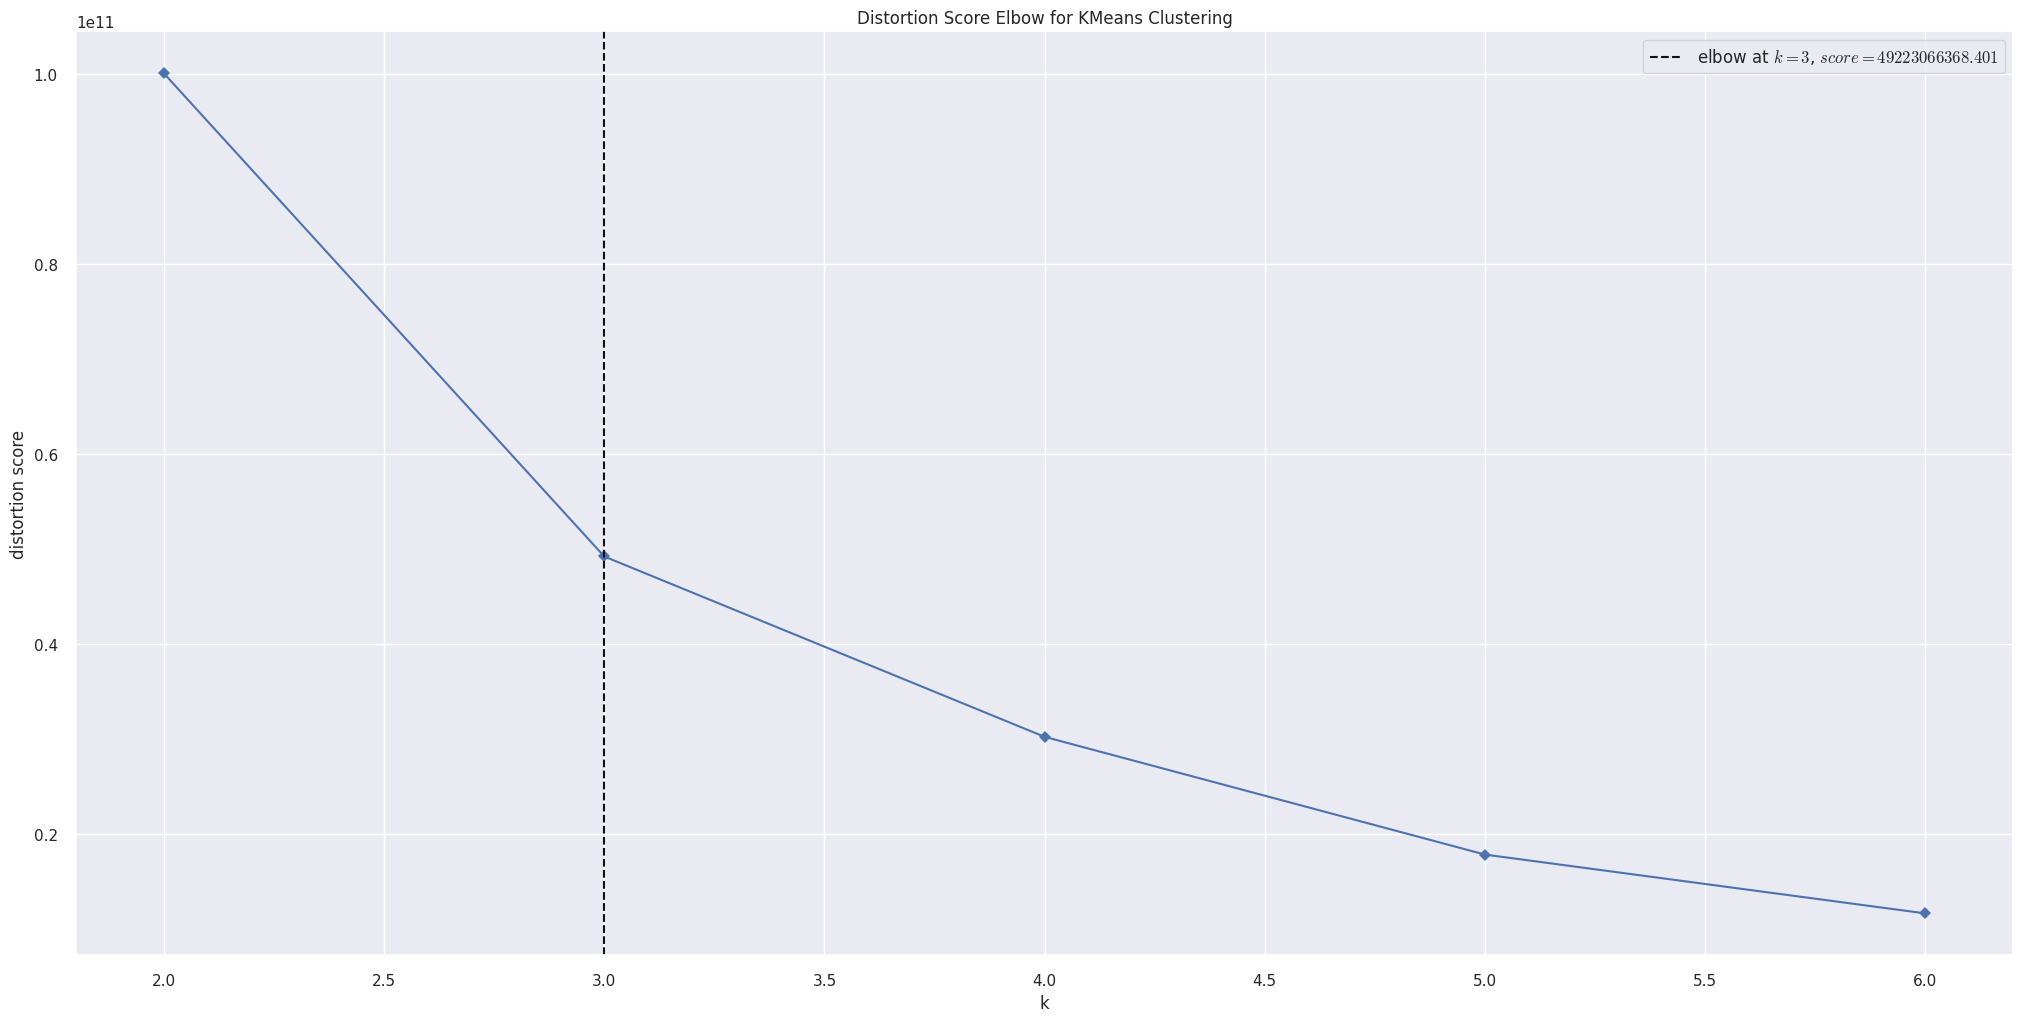

In [28]:
#@title { vertical-output: true}

clusters = [2, 3, 4, 5, 6, 7]


#Model Define
kmeans_model = KElbowVisualizer(KMeans(), k=clusters, init='random',
                                n_init=10, random_state=42, metric='distortion',
                                timings=False)

#Model Training
kmeans_model.fit(X)

#Elbow Method - WSS (Within-Cluster Sum of Squares)
kmeans_model.show();


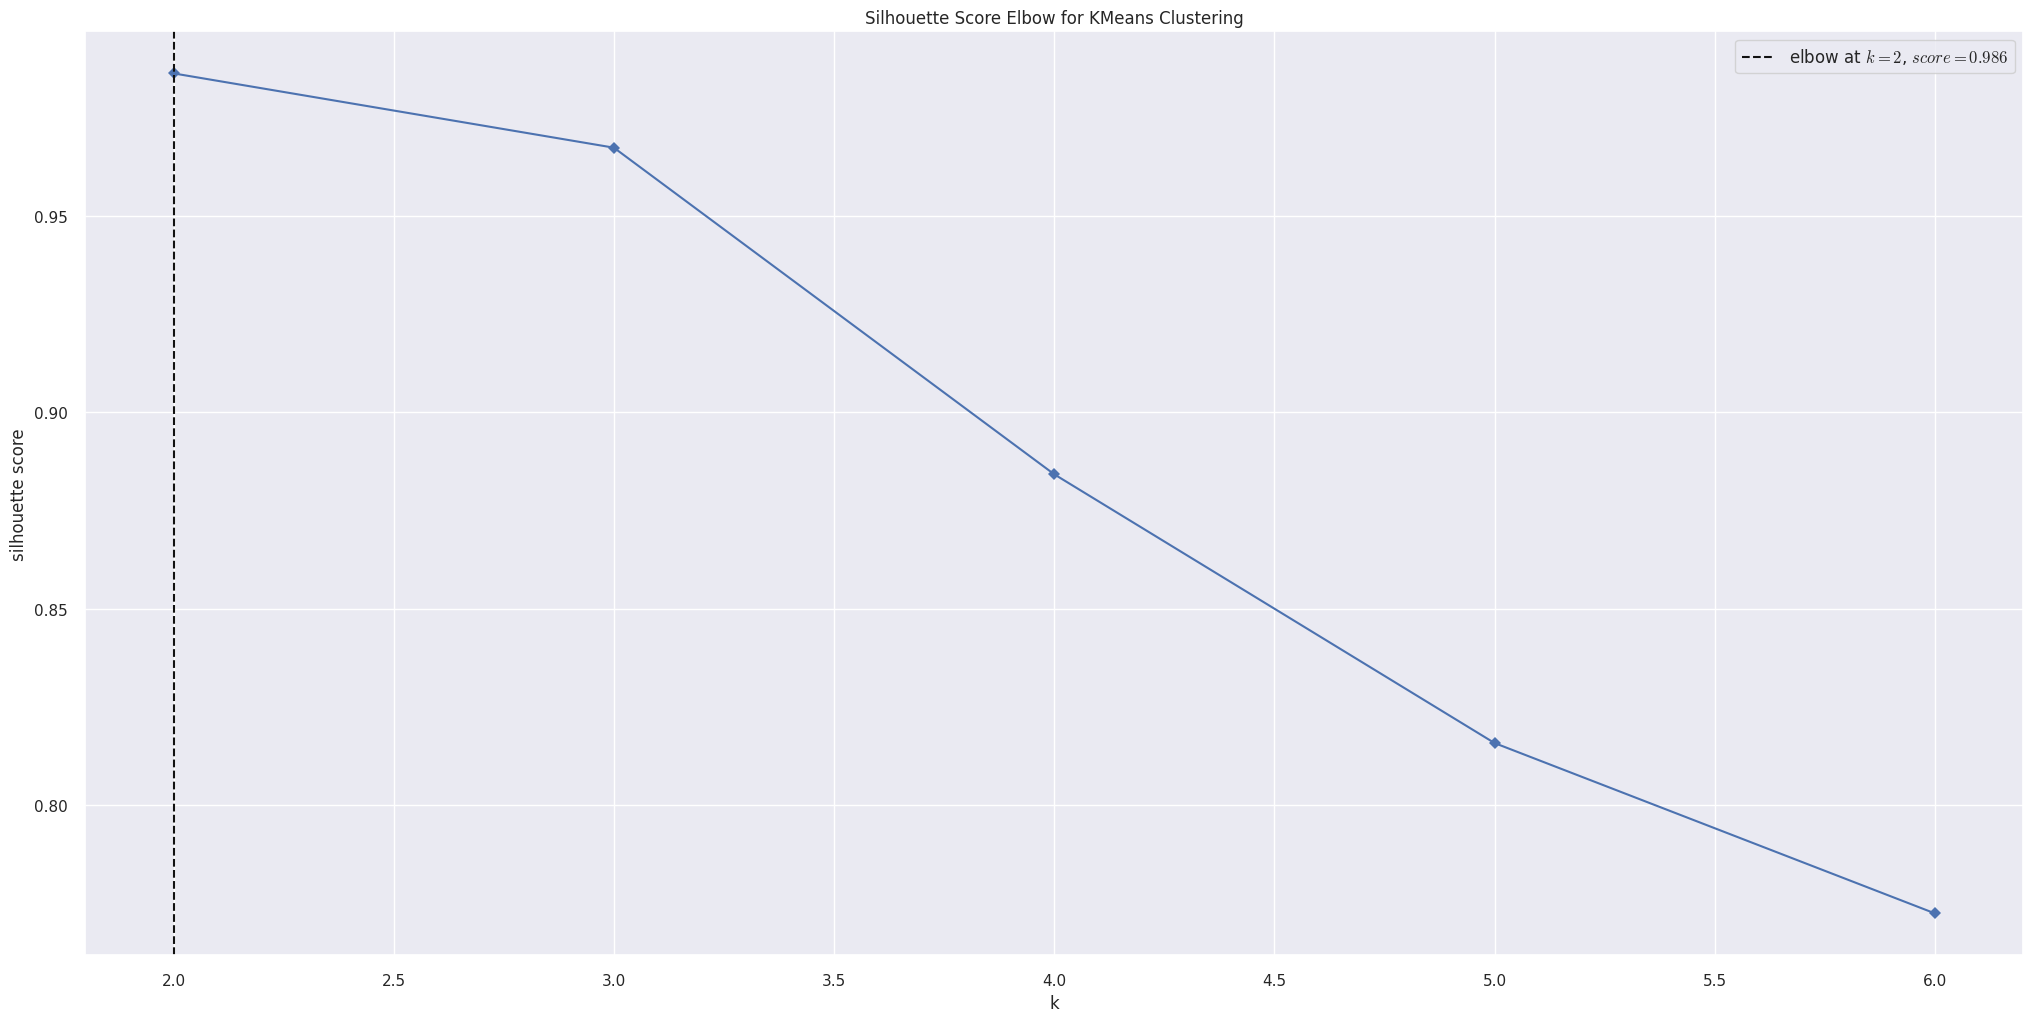

In [29]:
#@title { vertical-output: true}
#Model Define
kmeans_model = KElbowVisualizer(KMeans(), k=clusters, init='random',
                                n_init=10, random_state=42, metric='silhouette',
                                timings=False)

#Model Training
kmeans_model.fit(X)

#Silhouette Score - (Metric value for each cluster)
kmeans_model.show();

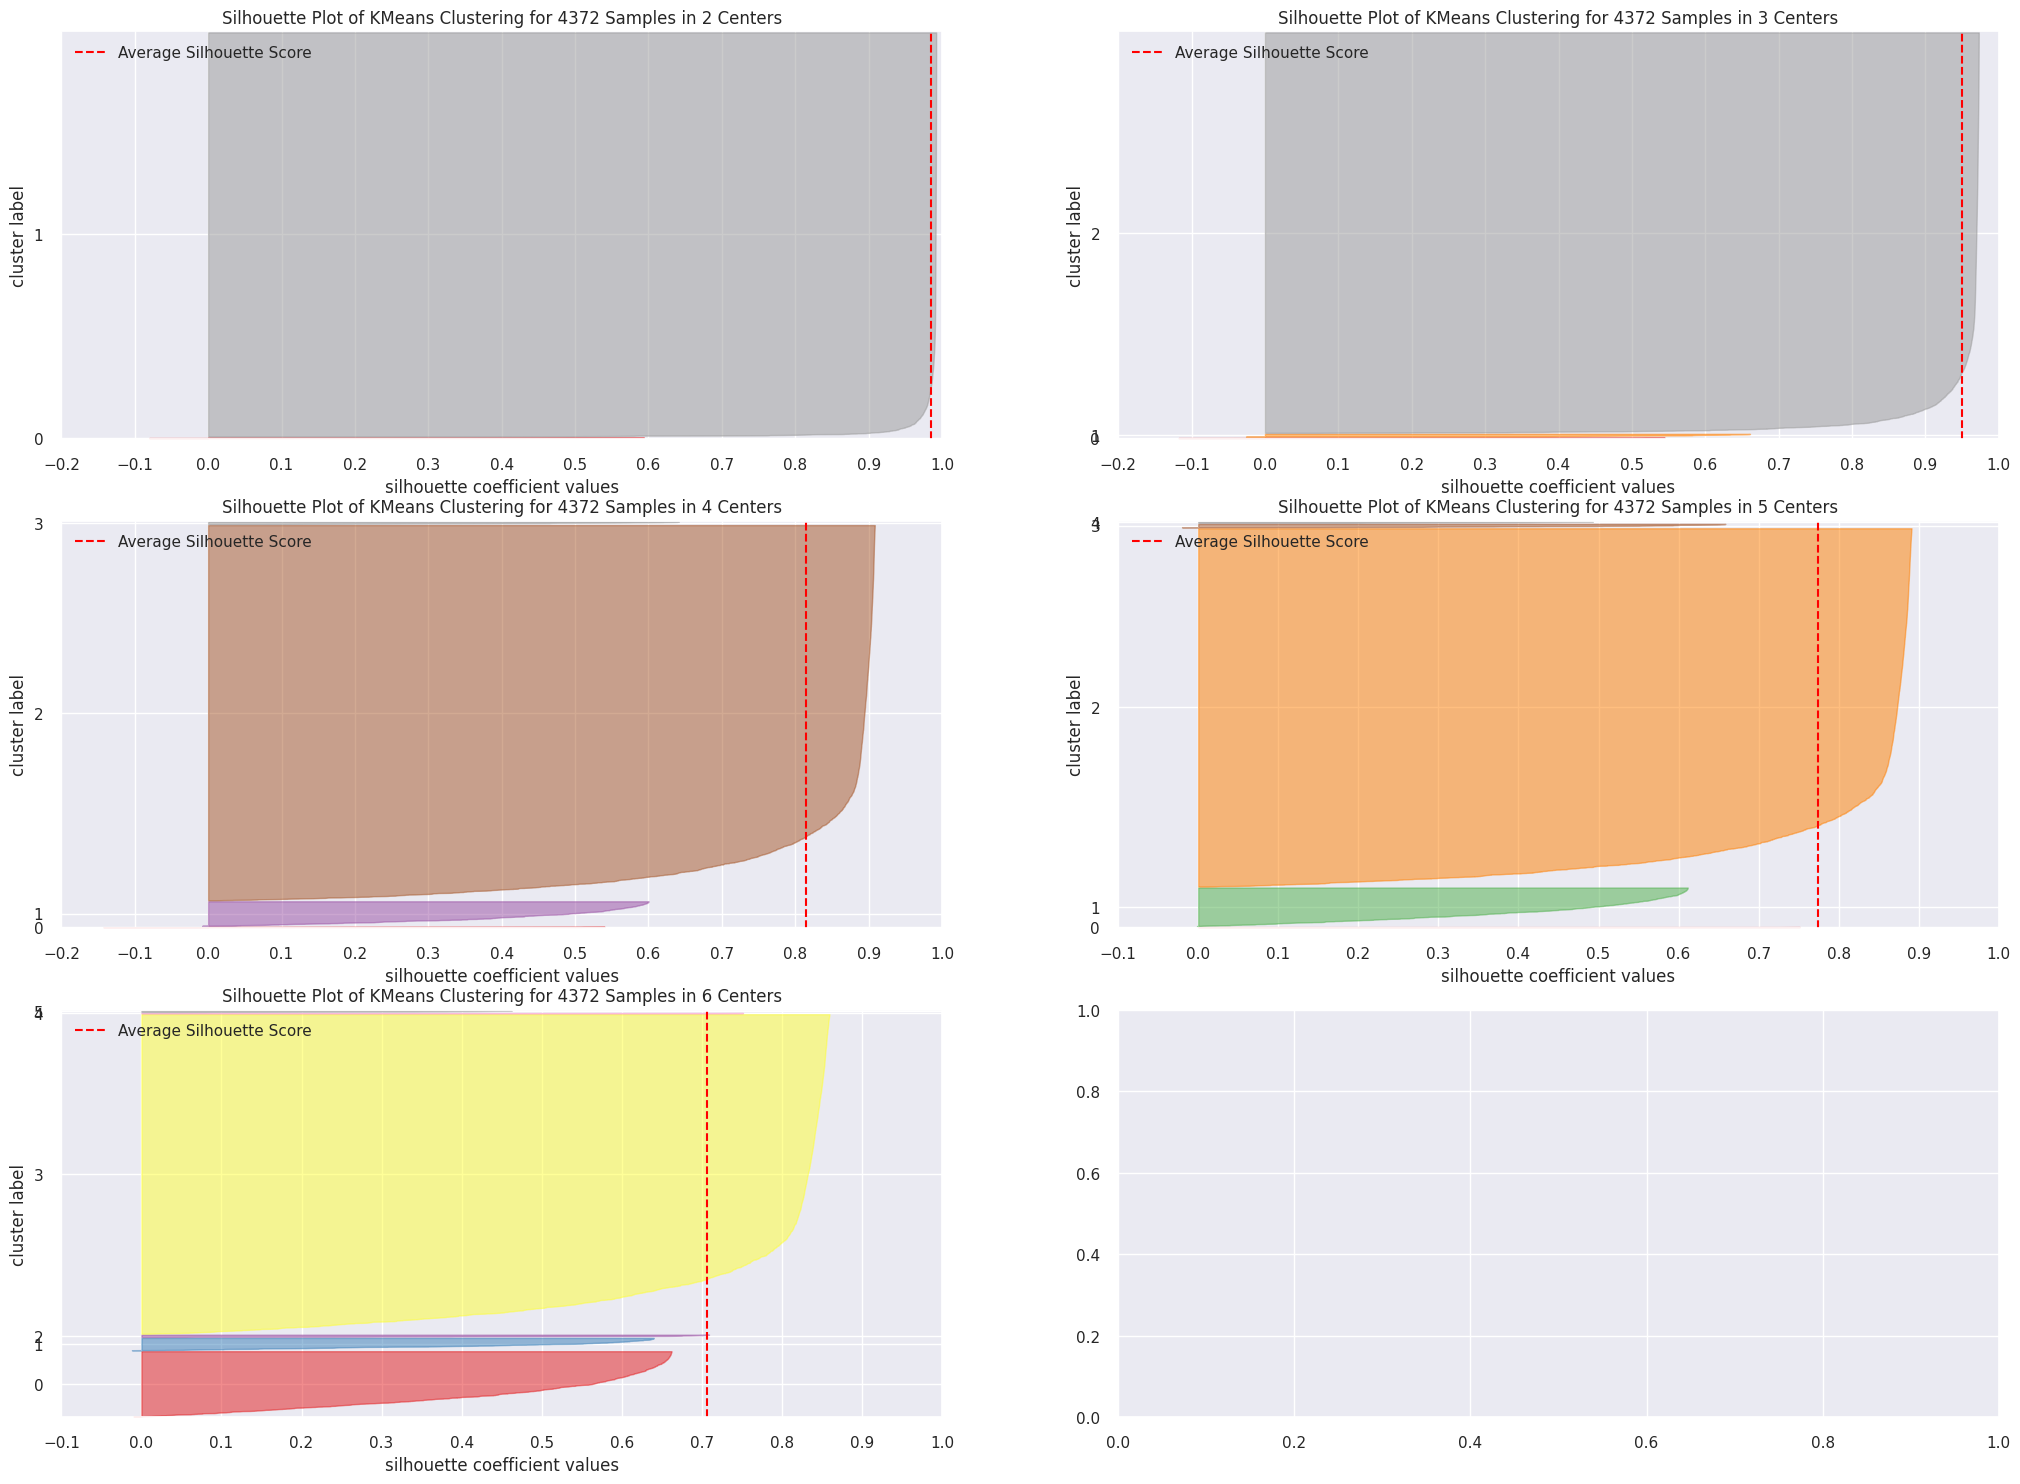

In [40]:
fig, ax = plt.subplots(3, 2, figsize=(25,18))


for i in clusters:
    #Model Define
    kmeans = KMeans( n_clusters = i, init='random', n_init=10,
                     max_iter=300, random_state=42)
    q, mod = divmod(i, 2)

    kmeans_model = SilhouetteVisualizer(kmeans, metric='silhouette',
                                        collors='yellowbrick', timings=False,
                                        ax=ax[q-1][mod])

    #Model Training
    kmeans_model.fit(X)

    #Silhouette Score - Silhouette Distribution Visualizer for each cluster
    kmeans_model.finalize();

# 8.0 MODEL TRAINING

In [31]:
k = 3

#Model definition
kmeans_model = KMeans(n_clusters=k, init='random', random_state=42, n_init=10, max_iter=300)

#Model Training
kmeans_model.fit(X)

#Labeling
labels = kmeans_model.labels_

In [32]:
#WSS (Within-Cluster Sum of Square)
print(f'WSS value: {kmeans_model.inertia_}')

#SS (Silhouette Score)
print(f'Silhouette Score: {silhouette_score(X, labels)}')

WSS value: 52830442008.00699
Silhouette Score: 0.9494677566681544


# 9.0 CLUSTER ANALYSIS

In [33]:
df9 = df7.copy()

## 9.1  Visualization Inspection

In [34]:
df9['cluster'] = labels
df9.head()

,customer_id,revenue,frequency,recency,cluster
0,12346,0.00,2,325,2
1,12347,4310.00,7,2,2
2,12348,1797.24,4,75,2
3,12349,1757.55,1,18,2
4,12350,334.40,1,310,2


In [35]:
fig = px.scatter_3d(df9, x='recency', y='frequency', z='revenue', color='cluster')
fig.show()

## 9.2 Cluster Profile

In [36]:
#Number of Customers
df_customer = df9[['customer_id', 'cluster']].groupby('cluster').count().reset_index()
df_customer = df_customer.rename(columns={'customer_id': 'total_customers'})
df_customer['perc_customers'] = 100*(df_customer['total_customers']/df_customer['total_customers'].sum())

#Avg Revenue
df_revenue = df9[['cluster', 'revenue']].groupby('cluster').mean().reset_index()
df_revenue = df_revenue.rename(columns={'customer_id': 'avg_revenue'})

#Avg Frequency
df_frequency = df9[['cluster', 'frequency']].groupby('cluster').mean().reset_index()
df_frequency = df_frequency.rename(columns={'frequency': 'avg_frequency'})

#Avg Recency
df_recency = df9[['cluster', 'recency']].groupby('cluster').mean().reset_index()
df_recency = df_recency.rename(columns={'recency': 'avg_recency'})


df_profile = pd.merge(df_customer, df_revenue, how='left', on='cluster')
df_profile = pd.merge(df_profile, df_frequency, how='left', on='cluster')
df_profile = pd.merge(df_profile, df_recency, how='left', on='cluster')

df_profile

,cluster,total_customers,perc_customers,revenue,avg_frequency,avg_recency
0,0,6,0.137237,182181.981667,89.000000,7.166667
1,1,31,0.709058,40543.517742,53.290323,13.290323
2,2,4335,99.153705,1372.577826,4.614533,92.257901


## Cluster 00: (Candidato à Insider)

*   Número de Customers = 6 (0.13% da base de dados)
*   Recência Média = 7 dias
*   Compras em Média = 89 compras
*   Receita Média = $182181,98

## Cluster 01: (Estudo de Viabilidade ao programa Insider)

*   Número de Customers = 31 (0.70% da base de dados)
*   Recência Média = 13 dias
*   Compras em Média =  53 compras
*   Receita Média = $40543,51

## Cluster 02: (Não Selecionados)

*   Número de Customers = 4335 (99,15% da base de dados)
*   Recência Média = 92 dias
*   Compras em Média = 5 compras
*   Receita Média = $1372,57



#   10.0 DEPLOY TO PRODUCTION